# Time Series forecasting 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\ASUS\Downloads\Compressed\IOT-temp.csv\IOT-temp.csv")

In [3]:
df.head()

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31,In


### Pre Processing

In [4]:
df.isna().sum()

id            0
room_id/id    0
noted_date    0
temp          0
out/in        0
dtype: int64

In [5]:
in_series = df[df['out/in'] == 'In'][['temp']].values
in_series

array([[29],
       [29],
       [31],
       ...,
       [31],
       [31],
       [31]], dtype=int64)

In [6]:
in_series.shape

(20345, 1)

In [7]:
in_series = np.array(in_series , 'float')

In [8]:
in_series

array([[29.],
       [29.],
       [31.],
       ...,
       [31.],
       [31.],
       [31.]])

In [9]:
out_series = df[df['out/in'] == 'Out'][['temp']]

In [10]:
out_series = np.array(out_series , 'float')

In [11]:
out_series

array([[41.],
       [41.],
       [42.],
       ...,
       [32.],
       [32.],
       [32.]])

In [12]:
len(in_series)

20345

In [13]:
len(out_series)

77261

In [14]:
def plot_series(series):
    plt.figure(figsize= (12 , 6))
    plt.plot(series)
    plt.show()

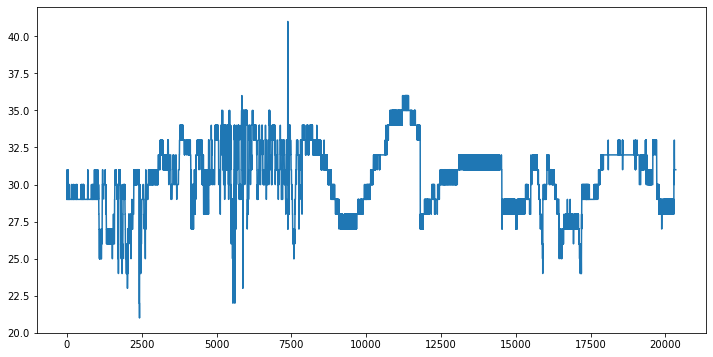

In [15]:
plot_series(in_series)

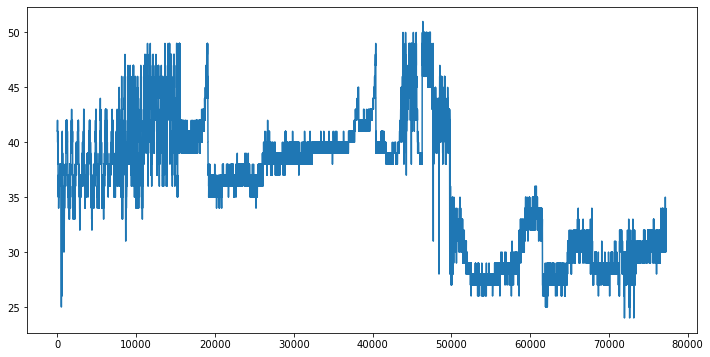

In [16]:
plot_series(out_series)

In [17]:
def normalize_series(series):
    original_min = min(series)
    original_max = max(series)
    print(original_max)
    series = (series - min(series)) / (max(series) - min(series))
    return series , original_max , original_min

In [18]:
series , original_max , original_min = normalize_series(in_series)
original_max

[41.]


array([41.])

In [19]:
def de_normalize_series(normalized_series):
    series = (normalized_series * (original_max - original_min)) + original_min
    return series

In [20]:
original = de_normalize_series(series)
original

array([[29.],
       [29.],
       [31.],
       ...,
       [31.],
       [31.],
       [31.]])

In [21]:
split_size = .8
window_size = 30
batch_size = 32
buffer_size = 1000

In [22]:
import tensorflow as tf
def windowed_series(series , window_size ,batch_size, buffer_size):
    series = tf.data.Dataset.from_tensor_slices(series)
    series = series.window( window_size +1 , shift = 1 , drop_remainder = True)
    series = series.flat_map(lambda x: x.batch(window_size + 1))
    series = series.map(lambda window: (window[:window_size] , window[window_size:]))
    series = series.shuffle(buffer_size)
    series = series.batch(batch_size).prefetch(1)
    return series

In [23]:
train_in_set_size = int(split_size * len(series))
train_in_set = series[train_in_set_size :]
validation_in_set = series[: train_in_set_size]

In [24]:
windowed_train_inset = windowed_series(train_in_set , window_size , batch_size , buffer_size)
train_in_set

array([[0.45],
       [0.45],
       [0.5 ],
       ...,
       [0.5 ],
       [0.5 ],
       [0.5 ]])

In [25]:
print(len(train_in_set))
len(list(windowed_train_inset))

4069


127

In [26]:
for x , y in windowed_train_inset.take(1):
    print(x.numpy().shape)
    print(y.numpy().shape)

(32, 30, 1)
(32, 1, 1)


In [27]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32 , kernel_size = 3 , padding = 'causal' , activation = 'relu' , input_shape = [window_size , 1]),
    tf.keras.layers.LSTM(64 , return_sequences = True ),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(10 , activation = 'relu'),
    tf.keras.layers.Dense(1)
])

model_init_weights = model.get_weights()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 32)            128       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            24832     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 58,645
Trainable params: 58,645
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.input.shape

TensorShape([None, 30, 1])

In [29]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

model.compile(loss = tf.keras.losses.Huber() , optimizer = tf.keras.optimizers.SGD(momentum = .9) , metrics = ['mae'])

In [30]:
history = model.fit(windowed_train_inset , epochs = 10 , callbacks = [lr_scheduler])

Epoch 1/10
127/127 [==============================] - 6s 24ms/step - loss: 0.1091 - mae: 0.4560 - lr: 1.0000e-08
Epoch 2/10
127/127 [==============================] - 2s 17ms/step - loss: 0.1090 - mae: 0.4560 - lr: 1.1220e-08
Epoch 3/10
127/127 [==============================] - 2s 17ms/step - loss: 0.1090 - mae: 0.4560 - lr: 1.2589e-08
Epoch 4/10
127/127 [==============================] - 2s 17ms/step - loss: 0.1090 - mae: 0.4559 - lr: 1.4125e-08
Epoch 5/10
127/127 [==============================] - 2s 18ms/step - loss: 0.1090 - mae: 0.4559 - lr: 1.5849e-08
Epoch 6/10
127/127 [==============================] - 2s 18ms/step - loss: 0.1090 - mae: 0.4559 - lr: 1.7783e-08
Epoch 7/10
127/127 [==============================] - 2s 18ms/step - loss: 0.1090 - mae: 0.4558 - lr: 1.9953e-08
Epoch 8/10
127/127 [==============================] - 2s 18ms/step - loss: 0.1089 - mae: 0.4558 - lr: 2.2387e-08
Epoch 9/10
127/127 [==============================] - 2s 18ms/step - loss: 0.1089 - mae: 0.4557 

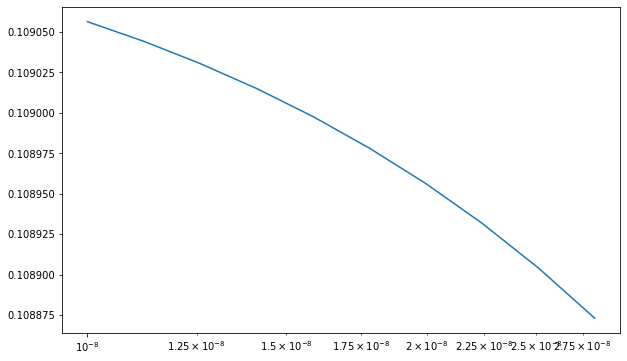

In [31]:
lr_list = 1e-8 * 10**(np.arange(10)/20)

loss = history.history['loss']
plt.figure(figsize = (10 , 6))
plt.semilogx(lr_list , loss)

In [32]:
lr_ = 1e-2

model_2 = model
model_2.set_weights(model_init_weights)

model_2.compile(loss = tf.keras.losses.Huber() , optimizer = tf.keras.optimizers.SGD(lr = lr_ , momentum = 0.9 ) ,metrics = ['mae'])

history_2 = model_2.fit(windowed_train_inset , epochs = 20)

Epoch 1/20
127/127 [==============================] - 4s 17ms/step - loss: 0.0064 - mae: 0.0880
Epoch 2/20
127/127 [==============================] - 2s 18ms/step - loss: 0.0030 - mae: 0.0656
Epoch 3/20
127/127 [==============================] - 2s 18ms/step - loss: 0.0024 - mae: 0.0577
Epoch 4/20
127/127 [==============================] - 2s 18ms/step - loss: 0.0015 - mae: 0.0454
Epoch 5/20
127/127 [==============================] - 2s 18ms/step - loss: 8.4755e-04 - mae: 0.0327
Epoch 6/20
127/127 [==============================] - 2s 18ms/step - loss: 4.3832e-04 - mae: 0.0225
Epoch 7/20
127/127 [==============================] - 2s 17ms/step - loss: 3.2171e-04 - mae: 0.0169
Epoch 8/20
127/127 [==============================] - 2s 17ms/step - loss: 3.0491e-04 - mae: 0.0157
Epoch 9/20
127/127 [==============================] - 2s 18ms/step - loss: 3.0632e-04 - mae: 0.0156
Epoch 10/20
127/127 [==============================] - 2s 18ms/step - loss: 3.1067e-04 - mae: 0.0158
Epoch 11/20
127

In [33]:
def model_forecast(model , series , window_size , batch_size):
    series = tf.data.Dataset.from_tensor_slices(series)
    series = series.window(window_size , shift = 1 , drop_remainder = True)
    series = series.flat_map(lambda win: win.batch(window_size))
    series = series.batch(batch_size)
    predictions = model.predict(series)
    return predictions

In [34]:
predictions = model_forecast(model , validation_in_set , window_size , batch_size)

508/508 [==============================] - 4s 7ms/step


In [35]:
results = np.array(predictions).squeeze()

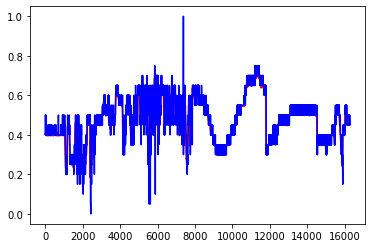

<Figure size 720x432 with 0 Axes>

In [36]:
plt.plot(results, 'r' , label='predictions')
plt.plot(validation_in_set , 'b' , label = 'actual')
plt.figure(figsize = (10 , 6))
plt.show()

# MSE

In [37]:
np.mean(tf.keras.metrics.mean_squared_error(validation_in_set, results))

0.024277749

# MAE

In [38]:
np.mean(tf.keras.metrics.mean_absolute_error(validation_in_set, results))

0.12529953

##### the second series coming form out sensor

In [39]:
out_series , original_max_outseries , original_min_outseries= normalize_series(out_series)


train_out_set_size = int(split_size * len(out_series))
train_out_series = out_series[:train_out_set_size]
validate_out_series = out_series[train_out_set_size:]

[51.]


In [40]:
validate_out_series

array([[0.14814815],
       [0.14814815],
       [0.14814815],
       ...,
       [0.2962963 ],
       [0.2962963 ],
       [0.2962963 ]])

In [41]:
windowed_train_out_ser = windowed_series(train_out_series , window_size , batch_size , buffer_size)

In [42]:
model_3 = model

model_3.set_weights(model_init_weights)


lr_scheduler_outseries = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (1e-8 *10 **(epoch / 20)))

model_3.compile(loss = tf.keras.losses.Huber() , optimizer = tf.keras.optimizers.SGD( momentum = 0.9 ) ,metrics = ['mae'])

history_3 = model_3.fit(windowed_train_out_ser , epochs = 5 , callbacks = [lr_scheduler_outseries])

Epoch 1/5
1931/1931 [==============================] - 36s 18ms/step - loss: 0.1565 - mae: 0.5264 - lr: 1.0000e-08
Epoch 2/5
1931/1931 [==============================] - 34s 18ms/step - loss: 0.1562 - mae: 0.5259 - lr: 1.1220e-08
Epoch 3/5
1931/1931 [==============================] - 34s 18ms/step - loss: 0.1559 - mae: 0.5254 - lr: 1.2589e-08
Epoch 4/5
1931/1931 [==============================] - 34s 18ms/step - loss: 0.1556 - mae: 0.5248 - lr: 1.4125e-08
Epoch 5/5
1931/1931 [==============================] - 34s 18ms/step - loss: 0.1552 - mae: 0.5241 - lr: 1.5849e-08


In [43]:
lr_model_3 = 1e-2
model_3 = model

model_3.set_weights(model_init_weights)



model_3.compile(loss = tf.keras.losses.Huber() , optimizer = tf.keras.optimizers.SGD( momentum = 0.9 , lr = lr_model_3 ) , metrics = ['mae'])

history_3 = model_3.fit(windowed_train_out_ser , epochs = 5)

Epoch 1/5
1931/1931 [==============================] - 36s 17ms/step - loss: 0.0014 - mae: 0.0303
Epoch 2/5
1931/1931 [==============================] - 34s 18ms/step - loss: 4.1641e-04 - mae: 0.0183
Epoch 3/5
1931/1931 [==============================] - 34s 18ms/step - loss: 4.0057e-04 - mae: 0.0180
Epoch 4/5
1931/1931 [==============================] - 34s 18ms/step - loss: 3.8694e-04 - mae: 0.0177
Epoch 5/5
1931/1931 [==============================] - 34s 18ms/step - loss: 3.7769e-04 - mae: 0.0176


482/482 [==============================] - 4s 7ms/step


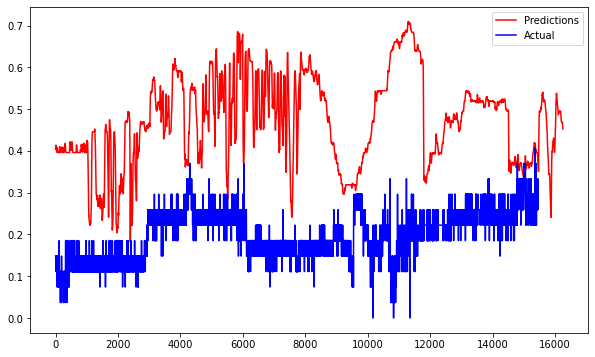

In [44]:
predictions_out_series = model_forecast(model_3 , validate_out_series, window_size , batch_size)
results_out_series = np.array(predictions).squeeze()

plt.figure(figsize = (10 , 6))
plt.plot(results_out_series , 'r' , label = 'Predictions')
plt.plot(validate_out_series ,'b' , label = 'Actual')
plt.legend()
plt.show()

# MSE

In [46]:
print(np.mean(tf.keras.metrics.mean_squared_error(validate_out_series , results_out_series)))

0.08990409


# MAE

In [47]:
print(np.mean(tf.keras.metrics.mean_absolute_error(validate_out_series , results_out_series)))

0.27537143
